## Вступ

Технічним завданням є створення конвертаційної нейронної моделі, яка здатна сегментувати зображення. Прикладом зображення є знімки спутника, які були дропнуті на дрібніші фото для подальшої роботи. Метою моделі є сегментація кораблів на знімках. \
Для роботи я встановлюю тільки 2 файла - файл зі знімками для навчання та файл із масковою послідовністю. Надалі я поділю навчальний набір на три частини та провірю якість створеної моделі.

Гайда за роботу!

## Розвідувальний аналіз

Для початку імпортуємо усі бібліотеки необхідні для роботи:

In [1]:
import os

from tqdm import tqdm

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

import cv2

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, Dense, Concatenate, GlobalAveragePooling2D, Dropout, UpSampling2D, Conv2D, MaxPooling2D, Activation

tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Встановлюємо необхідну для роботи директорію.

In [2]:
path = 'C:/Users/Vladislav/Desktop/Airbus'
path_to_train = 'C:/Users/Vladislav/Desktop/Airbus/train_v2'
os.chdir(path)

In [3]:
print('Train file have {} images. \nShape of image is {}.'.format(len(os.listdir(path_to_train)), 
                                                                  cv2.imread(path_to_train + '/' + '00003e153.jpg').shape[:2]))

Train file have 192556 images. 
Shape of image is (768, 768).


Завантажуємо набір із масковою послідовністю та провіряємо його розмірність.

In [4]:
df_segment = pd.read_csv('train_ship_segmentations_v2.csv')
df_segment.shape

(231723, 2)

Дивимось його перших десять строк, щоб отримати розуміння про зовнішній вигляд.

In [5]:
df_segment.head(10)

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
5,000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
6,000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
7,000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...
8,0001b1832.jpg,NaN
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...


Дивимось загальну інформацію по даному набору.

In [6]:
df_segment.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 231723 entries, 0 to 231722
Data columns (total 2 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   ImageId        231723 non-null  object
 1   EncodedPixels  81723 non-null   object
dtypes: object(2)
memory usage: 3.5+ MB


Перевіряємо чи усі зображення відкриваються. (Як наведений нижче код можна оптимізувати чи існує альтернатива для виявлення поломки у зображеннях?)

In [7]:
# error_img = []

# for img_name in tqdm(df_segment['ImageId']):
#     try:
#         cv2.imread(path_to_train + '/' + img_name)
#     except Error:
#         error_img.append(img_name)
        
# print('Кількість пошкоджених файлів: {}.'.format(len(error_img)))

Видаляємо пошкоджене зображення з фрейму.

In [8]:
df_segment = df_segment[~df_segment['ImageId'].isin(['6384c3e78.jpg'])]

Дивимось, скільки всього зображень з кораблями і без них.

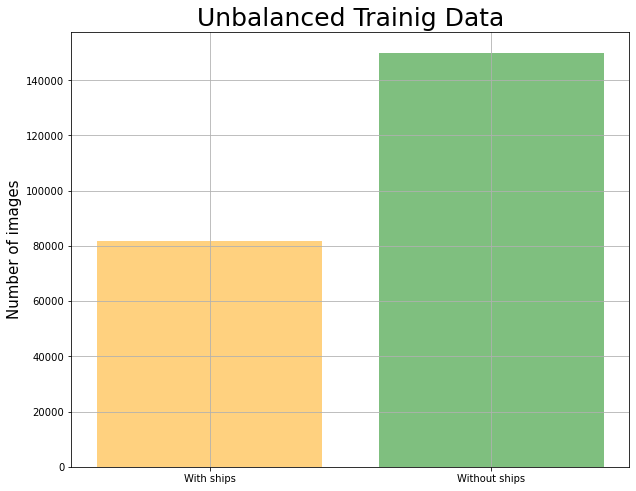

In [9]:
df_with_ships = df_segment.dropna()
df_without_ships = df_segment[df_segment['EncodedPixels'].isna()] 

plt.figure(figsize=(10, 8))

plt.bar(['With ships', 'Without ships'], [df_with_ships.shape[0], df_without_ships.shape[0]], color = ['orange','green'], alpha=0.5)
plt.ylabel('Number of images',fontsize=15)
plt.title('Unbalanced Trainig Data', fontsize=25)

plt.grid()

plt.show()

Ділимо дані з кораблями по групам, щоб подивитися розподіл по кількістю кораблів.

In [10]:
df_group_with_ships = df_with_ships.copy()

df_group_with_ships = df_group_with_ships.groupby('ImageId').count().reset_index()
df_group_with_ships['amount_ships'] = df_group_with_ships['EncodedPixels']

df_group_with_ships

,ImageId,EncodedPixels,amount_ships
0,000155de5.jpg,1,1
1,000194a2d.jpg,5,5
2,00021ddc3.jpg,9,9
3,0002756f7.jpg,2,2
4,00031f145.jpg,1,1
...,...,...,...
42551,fff77c602.jpg,1,1
42552,fff909871.jpg,1,1
42553,fffcb6464.jpg,1,1
42554,fffd924fb.jpg,2,2


In [11]:
sorted(df_group_with_ships['amount_ships'].unique())

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

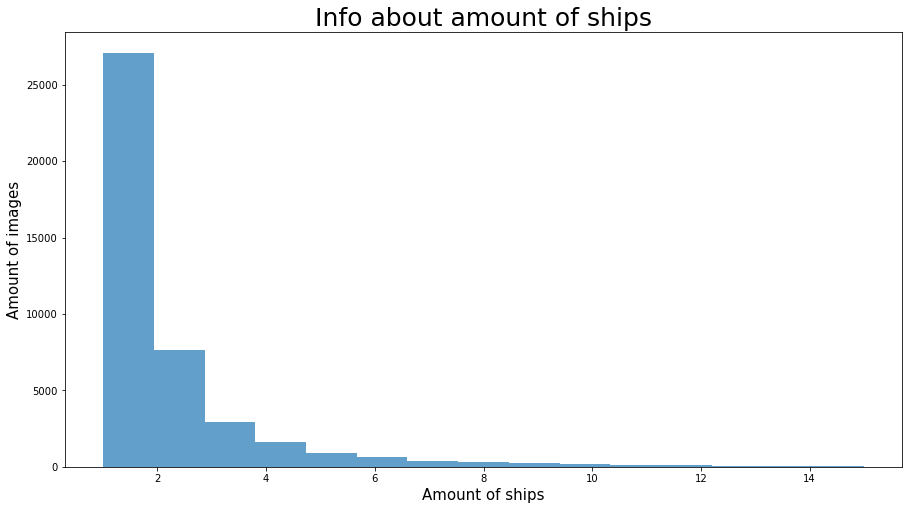

In [12]:
plt.figure(figsize=(15, 8))

info = plt.hist(df_group_with_ships['amount_ships'], bins=15, alpha=0.7)

plt.title('Info about amount of ships', fontsize=25)
plt.xlabel('Amount of ships', fontsize=15)
plt.ylabel('Amount of images', fontsize=15)

plt.show()

In [13]:
df_0 = pd.DataFrame(info[0], columns=['Amount of images'])
df_ind = pd.DataFrame(np.arange(1, 16), columns=['Amount of ships']) 

df = pd.concat([df_ind, df_0], axis=1)
df = df.set_index('Amount of ships')

df

,Amount of images
Amount of ships,
1,27104.0
2,7674.0
3,2954.0
4,1622.0
5,925.0
6,657.0
7,406.0
8,318.0
9,243.0


Найбільша кількість зображень має 1 корабель.

Далі дивимось, яку площу мають кораблі та видаляємо ті зображення, які занадто малі.

In [14]:
def rle_to_box(rle, shape=(768, 768, 1)):
   
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
    starts -= 1
    ends = starts + lengths
   
    y0 = starts % shape[0]
    y1 = y0 + lengths
    
    if np.any(y1 > shape[0]):
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
   
    x0 = starts // shape[0]
    x1 = ends // shape[0]
    
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    xC = (x1+x0)/(2*768)
    yC = (y1+y0)/(2*768)
    h = np.abs(y1-y0)/768
    w = np.abs(x1-x0)/768

    return [xC, yC, h, w]

In [15]:
df_segment['bbox'] = df_segment['EncodedPixels'].map(lambda x: rle_to_box(x) if isinstance(x, str) else np.NaN)

df_segment

,ImageId,EncodedPixels,bbox
0,00003e153.jpg,NaN,NaN
1,0001124c7.jpg,NaN,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,"[0.5149739583333334, 0.62890625, 0.046875, 0.1..."
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,"[0.625, 0.38671875, 0.026041666666666668, 0.02..."
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,"[0.09830729166666667, 0.4967447916666667, 0.01..."
...,...,...,...
231718,fffedbb6b.jpg,NaN,NaN
231719,ffff2aa57.jpg,NaN,NaN
231720,ffff6e525.jpg,NaN,NaN
231721,ffffc50b4.jpg,NaN,NaN


In [16]:
df_segment['bboxArea'] = df_segment['bbox'].map(lambda x: x[2] * 768 * x[3] * 768 if x == x else 0)

df_segment

,ImageId,EncodedPixels,bbox,bboxArea
0,00003e153.jpg,NaN,NaN,0.0
1,0001124c7.jpg,NaN,NaN,0.0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,"[0.5149739583333334, 0.62890625, 0.046875, 0.1...",3708.0
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,"[0.625, 0.38671875, 0.026041666666666668, 0.02...",440.0
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,"[0.09830729166666667, 0.4967447916666667, 0.01...",153.0
...,...,...,...,...
231718,fffedbb6b.jpg,NaN,NaN,0.0
231719,ffff2aa57.jpg,NaN,NaN,0.0
231720,ffff6e525.jpg,NaN,NaN,0.0
231721,ffffc50b4.jpg,NaN,NaN,0.0


In [17]:
df_segment[~df_segment['EncodedPixels'].isna()]['bboxArea'].describe()

count    81723.000000
mean      3918.225261
std       8041.480982
min          0.000000
25%        182.000000
50%        780.000000
75%       3485.000000
max      77244.000000
Name: bboxArea, dtype: float64

Є зображення в яких площа рамки дорінює 0 та 77244.

Дані, у яких площа рамки ближче до 0, необхідно видалити. А дані в яких значення більше 4000 необхідно провірити.

In [18]:
df = df_segment[~df_segment['EncodedPixels'].isna()]
df[df['bboxArea'] < 4]

,ImageId,EncodedPixels,bbox,bboxArea
2272,02776139a.jpg,33570 2,"[0.055989583333333336, 0.7109375, 0.0026041666...",0.0
87655,60ca4f877.jpg,230178 2,"[0.3893229166666667, 0.7109375, 0.002604166666...",0.0
109952,79123fc78.jpg,426530 2,"[0.72265625, 0.3776041666666667, 0.00260416666...",0.0
128175,8d69a8637.jpg,426274 2,"[0.72265625, 0.044270833333333336, 0.002604166...",0.0
139720,9a39363b0.jpg,229922 2,"[0.3893229166666667, 0.3776041666666667, 0.002...",0.0
141123,9bba328fa.jpg,426786 2,"[0.72265625, 0.7109375, 0.0026041666666666665,...",0.0
191594,d3d5edcf0.jpg,506890 5,"[0.859375, 0.014973958333333334, 0.00651041666...",0.0
200045,dd38da47f.jpg,33314 2,"[0.055989583333333336, 0.3776041666666667, 0.0...",0.0
220629,f3cbca9b6.jpg,310282 5,"[0.5260416666666666, 0.014973958333333334, 0.0...",0.0
225511,f927e2b45.jpg,113674 5,"[0.19270833333333334, 0.014973958333333334, 0....",0.0


In [19]:
drop_index = df[df['bboxArea'] < 4].index

df_segment = df_segment.drop(index=drop_index)

Далі дивимося на великі значення.

In [20]:
df = df_segment[~df_segment['EncodedPixels'].isna()]
df[df['bboxArea'] > 4000]

,ImageId,EncodedPixels,bbox,bboxArea
29,0005d01c8.jpg,56010 1 56777 3 57544 6 58312 7 59079 9 59846 ...,"[0.20052083333333334, 0.8704427083333334, 0.18...",23124.0
30,0005d01c8.jpg,365871 1 366638 3 367405 6 368173 7 368940 9 3...,"[0.6712239583333334, 0.373046875, 0.08984375, ...",5451.0
32,0006c52e8.jpg,146366 1 147132 4 147899 5 148666 7 149432 10 ...,"[0.3880208333333333, 0.435546875, 0.3580729166...",59400.0
71,001234638.jpg,131064 1 131831 3 132599 5 133366 7 134133 9 1...,"[0.3229166666666667, 0.6061197916666666, 0.167...",20124.0
79,001566f7c.jpg,70386 1 71152 4 71918 6 72685 8 73451 10 74218...,"[0.236328125, 0.697265625, 0.16276041666666666...",22625.0
...,...,...,...,...
231646,ffe89d4cb.jpg,63529 1 64296 3 65062 6 65829 7 66596 9 67363 ...,"[0.21028645833333334, 0.630859375, 0.240885416...",29415.0
231647,ffe89d4cb.jpg,79695 1 80462 3 81228 6 81995 7 82762 9 83529 ...,"[0.2526041666666667, 0.666015625, 0.27734375, ...",38766.0
231663,ffed6e788.jpg,158 17 925 20 1693 21 2460 21 3228 21 3995 21 ...,"[0.059895833333333336, 0.18619791666666666, 0....",6256.0
231690,fff77c602.jpg,133056 1 133823 4 134591 6 135358 8 136126 10 ...,"[0.40625, 0.19010416666666666, 0.2604166666666...",55600.0


Видно, що їх багато (аж 18530). Тому перевіримо критичне значення - 77244.

In [21]:
df[df['bboxArea'] == 77244]

,ImageId,EncodedPixels,bbox,bboxArea
28615,1fd8c725c.jpg,362542 1 363309 4 364077 5 364844 7 365611 10 ...,"[0.7747395833333334, 0.21744791666666666, 0.40...",77244.0
72673,5076d9724.jpg,165934 1 166701 4 167469 5 168236 7 169003 10 ...,"[0.44140625, 0.21744791666666666, 0.4088541666...",77244.0
200875,de1f86c7a.jpg,166190 1 166957 4 167725 5 168492 7 169259 10 ...,"[0.44140625, 0.55078125, 0.4088541666666667, 0...",77244.0
229735,fdc7fccc9.jpg,362798 1 363565 4 364333 5 365100 7 365867 10 ...,"[0.7747395833333334, 0.55078125, 0.40885416666...",77244.0


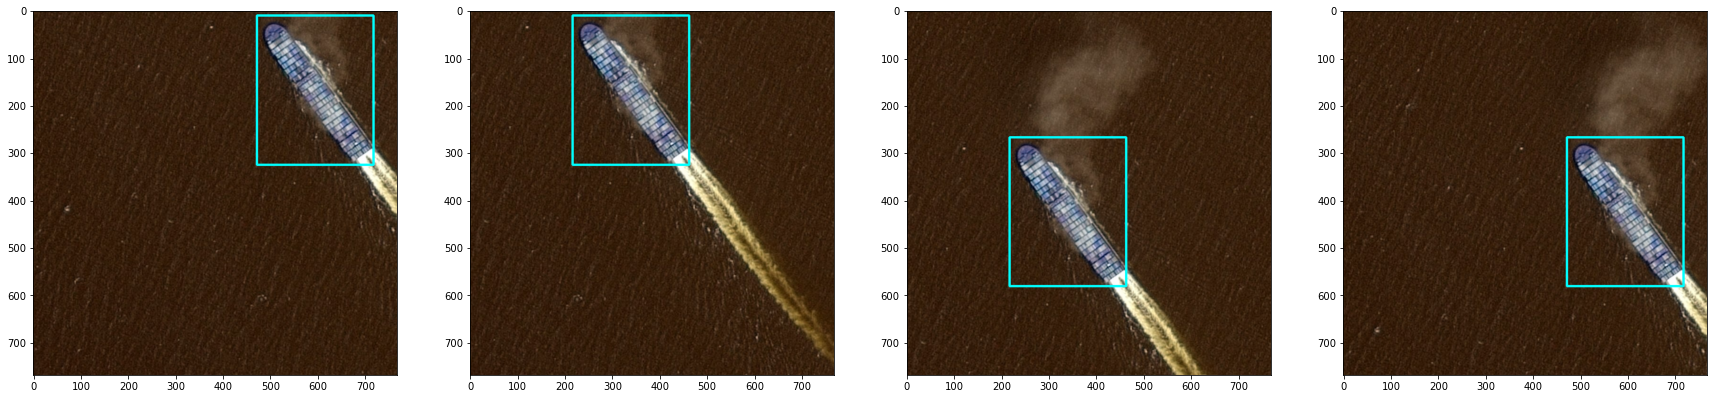

In [22]:
fig, axs = plt.subplots(1, 4, figsize=(30, 30))

i=0

for img_name, bbox in zip(df[df['bboxArea'] == 77244]['ImageId'], df[df['bboxArea'] == 77244]['bbox']):
    img = cv2.imread(path_to_train + '/' + img_name)
    
    x0 = int((bbox[0] - (bbox[3] / 2)) * 768)
    y0 = int((bbox[1] - (bbox[2] / 2)) * 768)
    x1 = int((bbox[0] + (bbox[3] / 2)) * 768)
    y1 = int((bbox[1] + (bbox[2] / 2)) * 768)

    rectangle = cv2.rectangle(img,
            pt1=(x0, y0),
            pt2=(x1, y1),
            color=(0, 255, 255),
            thickness=3)
    
    axs[i].imshow(img)
    axs[i].imshow(rectangle)
    
    i+=1

Квадрати нормальної форми та інформативні, тому можемо їх невидаляти.

Наступним кроком буде об'єднання масок в одну для зменшення дублікатів зображень.

Но перед цим вибираємо, яку частину інформації ми будемо використовувати (для запобігання перегрівання ноутбука). Для цього пропоную взяти не більше 500 з кожної групи та врівноважити кількістю зображень без кораблів.

Приступимо...

In [23]:
df = df.groupby('ImageId').count().reset_index()[['ImageId', 'EncodedPixels']]

list_of_image = []

for i in range(1, 16):
    images = df[df['EncodedPixels'] == i]['ImageId'].unique()[:500]
    
    images = images.tolist()
    list_of_image += images
    
print(len(list_of_image))

4620


Отримали 4620 зображення з кораблями. Далі необхідно добавити список зображень без кораблів такої ж довжини.

In [24]:
np.random.seed(1)

df_without_ships = df_segment[df_segment['EncodedPixels'].isna()]
df_without_ships = df_without_ships.sample(frac=1).reset_index(drop=True)
df_without_ships = df_without_ships['ImageId'].unique()[:4620]
list_without_ships = df_without_ships.tolist()

list_of_image += list_without_ships

print(len(list_of_image))

9240


Тепер можна зайнятися об'єднанням масок та приготуванням набору до навчання.

Маски, переважно, не зберігаються в растровому режимі, їх переводять у послідовність для кращого зберігання. Тому необхідно створити функцію, яка буде декодувати послідовність у матрицю.

Необхідно врахувати, що відсутність маски вказує на відсутність корабля, тому потрібно NaN перетворити у нульову матрицю.  

In [25]:
def rle_decode(mask_rle, shape=(768, 768, 1)):
    
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    
    if type(mask_rle) is str:
        s = mask_rle.split()
        starts, lengths = [np.asarray(x, dtype=int) for x in (s[::2], s[1::2])]
        starts -= 1
        ends = starts + lengths

        for lo, hi in zip(starts, ends):
            img[lo:hi] = 1

        img = img.reshape(shape)

        return img
    else:
        img = img.reshape(shape)
        
        return img

In [26]:
df_segment = pd.read_csv('train_ship_segmentations_v2.csv')

main_df = pd.DataFrame(columns=['ImageId', 'DecodedPixels'])

for img_name in tqdm(list_of_image):
    img = cv2.imread(path_to_train + '/' + img_name)
    mask = df_segment[df_segment['ImageId']==img_name]['EncodedPixels'].apply(lambda x: rle_decode(x)).sum(axis=0)
    
    df_mask = pd.DataFrame({'ImageId': [img], 'DecodedPixels': [mask]})
        
    main_df = pd.concat([main_df, df_mask])
        
main_df

100%|██████████████████████████████████████████████████████████████████████████████| 9240/9240 [07:54<00:00, 19.46it/s]


,ImageId,DecodedPixels
0,"[[[100, 83, 62], [99, 82, 61], [96, 79, 58], [...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[99, 99, 87], [110, 110, 98], [118, 116, 105...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[25, 34, 31], [28, 35, 30], [67, 67, 61], [1...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[41, 23, 0], [41, 23, 0], [41, 23, 0], [41, ...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[58, 55, 41], [38, 35, 21], [45, 42, 28], [4...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
...,...,...
0,"[[[83, 62, 30], [82, 61, 29], [84, 63, 31], [8...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[54, 47, 8], [62, 55, 16], [68, 61, 22], [67...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[81, 61, 36], [83, 63, 38], [83, 63, 38], [7...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."
0,"[[[62, 25, 0], [64, 27, 0], [65, 27, 3], [63, ...","[[[0], [0], [0], [0], [0], [0], [0], [0], [0],..."


Зробили так, щоб інформації було порівну і маски були готові до використання.

In [27]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9240 entries, 0 to 0
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   ImageId        9240 non-null   object
 1   DecodedPixels  9240 non-null   object
dtypes: object(2)
memory usage: 216.6+ KB


Подивимося, як виглядає зображення та його маска.

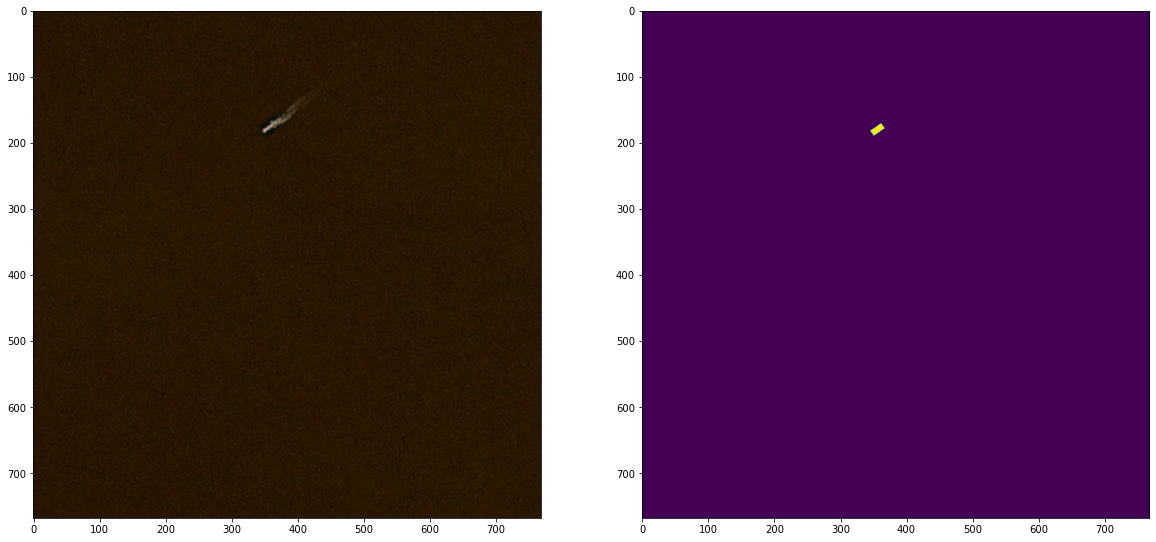

In [28]:
img, mask = main_df.iloc[3]

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].imshow(img)
axs[1].imshow(mask[..., 0].T)

plt.show()

Чудово.

Можемо приступати безпосередньо до навчання.

## Створення конвертаційної нейронної мережі

Для початку поділимо дані на тренувальний, валідаційний та тестовий набір.

In [29]:
main_df['label'] = main_df['DecodedPixels'].apply(lambda x: 0 if x is False else 1)

df_without_ships = main_df[main_df['label'] == 0]
df_with_ships = main_df[main_df['label'] == 1]

# Відділяємо тренувальний набір від тестового.
train_size_with_ships = int(df_with_ships.shape[0] * 0.7)
train_size_without_ships = int(df_without_ships.shape[0] * 0.7)

df_train_with_ships = df_with_ships[:train_size_with_ships]
df_train_without_ships = df_without_ships[:train_size_without_ships]

df_test_with_ships = df_with_ships[train_size_with_ships:]
df_test_without_ships = df_without_ships[train_size_without_ships:]

df_test = pd.concat([df_test_with_ships, df_test_without_ships])
df_test = df_test.sample(frac=1).reset_index(drop=True)

In [30]:
# Відділяємо валідаційний набір від тренувального.

valid_size_with_ships = int(df_train_with_ships.shape[0] * 0.3)
valid_size_without_ships = int(df_train_without_ships.shape[0] * 0.3)

df_valid_with_ships = df_train_with_ships[:valid_size_with_ships]
df_valid_without_ships = df_train_without_ships[:valid_size_without_ships]

df_valid = pd.concat([df_valid_with_ships, df_valid_without_ships])
df_valid = df_valid.sample(frac=1).reset_index(drop=True)
df_valid = df_valid[['ImageId', 'DecodedPixels']]

df_train_with_ships = df_with_ships[valid_size_with_ships:]
df_train_without_ships = df_without_ships[valid_size_without_ships:]

df_train = pd.concat([df_train_with_ships, df_train_without_ships])
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_train = df_train[['ImageId', 'DecodedPixels']]

Створюємо додаткову функцію, яка подаватиме файли нейромережі батчами для зменшення перенавантаження на оперативну пам'ять.

In [143]:
def keras_generator(df, batch_size):
    
    while True:
        x_batch = []
        y_batch = []
        
        for i in range(batch_size):
            img, mask = df.sample(1).values[0]
            
            img = cv2.resize(img, (256, 256))
            mask = cv2.resize(mask, (256, 256))
            
            x_batch += [img]
            y_batch += [mask]

        x_batch = np.array(x_batch) / 255.
        y_batch = np.array(y_batch)

        yield x_batch, np.expand_dims(y_batch, -1)

Дивимось, як виглядає батч.

In [102]:
for x, y in keras_generator(df_train, 30):
    break

In [103]:
x.shape, y.shape

((30, 256, 256, 3), (30, 256, 256, 1))

Дані готові, можемо розпочинати.

Для створення згорткової мережі використовується схема Vanilla Unet.

In [108]:
inp = Input(shape=(256, 256, 3))

conv_1_1 = Conv2D(64, (3, 3), padding='same')(inp)
conv_1_1 = Activation('relu')(conv_1_1)

pool_1 = MaxPooling2D(2)(conv_1_1)

conv_2_1 = Conv2D(128, (3, 3), padding='same')(pool_1)
conv_2_1 = Activation('relu')(conv_2_1)

pool_2 = MaxPooling2D(2)(conv_2_1)

conv_3_1 = Conv2D(256, (3, 3), padding='same')(pool_2)
conv_3_1 = Activation('relu')(conv_3_1)

pool_3 = MaxPooling2D(2)(conv_3_1)

up_1 = UpSampling2D(2, interpolation='bilinear')(pool_3)
conc_1 = Concatenate()([conv_3_1, up_1])

conv_up_1_1 = Conv2D(256, (3, 3), padding='same')(conc_1)
conv_up_1_2 = Activation('relu')(conv_up_1_1)

up_2 = UpSampling2D(2, interpolation='bilinear')(conv_up_1_2)
conc_2 = Concatenate()([conv_2_1, up_2])

conv_up_2_1 = Conv2D(128, (3, 3), padding='same')(conc_2)
conv_up_2_2 = Activation('relu')(conv_up_2_1)

up_3 = UpSampling2D(2, interpolation='bilinear')(conv_up_2_2)
conc_3 = Concatenate()([conv_1_1, up_3])

conv_up_3_1 = Conv2D(64, (3, 3), padding='same')(conc_3)
conv_up_3_2 = Activation('relu')(conv_up_3_1)

conv_up_4_1 = Conv2D(1, (3, 3), padding='same')(conv_up_3_2)
result = Activation('sigmoid')(conv_up_4_1)


vanil_unet = Model(inputs=inp, outputs=result)

Створюємо модель CheckPoint для відслідковування найкращого та останнього параметра моделі.

In [ ]:
best_w = keras.callbacks.ModelCheckpoint('vanil_unet_best.hdf5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=True,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

last_w = keras.callbacks.ModelCheckpoint('vanil_unet_last.hdf5',
                                monitor='val_loss',
                                verbose=0,
                                save_best_only=False,
                                save_weights_only=True,
                                mode='auto',
                                period=1)

callbacks = [best_w, last_w]

adam = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

vanil_unet.compile(adam, 'binary_crossentropy')

Дивимось структуру створеної мережі.

In [38]:
vanil_unet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 64) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           activation[0][0]                 
______________________________________________________________________________________________

Навчаємо створену модель.

In [144]:
tf.random.set_seed(5)

batch_size = 10

vanil_unet.fit_generator(keras_generator(df_train, batch_size),
              steps_per_epoch=100,
              epochs=5,
              callbacks=callbacks,
              verbose=1,
              validation_data=keras_generator(df_valid, batch_size),
              validation_steps=50,
              class_weight=None,
              max_queue_size=10,
              workers=1,
              use_multiprocessing=False,
              shuffle=True,
              initial_epoch=0)

Epoch 1/5
  4/100 [>.............................] - ETA: 27:44 - loss: 0.0143

KeyboardInterrupt: 

Робимо передбачення для 30 зображень в тестовому наборі.

In [115]:
for x, y in keras_generator(df_valid, batch_size):
    break

prediction = vanil_unet.predict(x,
                        verbose=1)

1/1 [==============================] - 9s 9s/step


Перевіряємо якість сегментування.

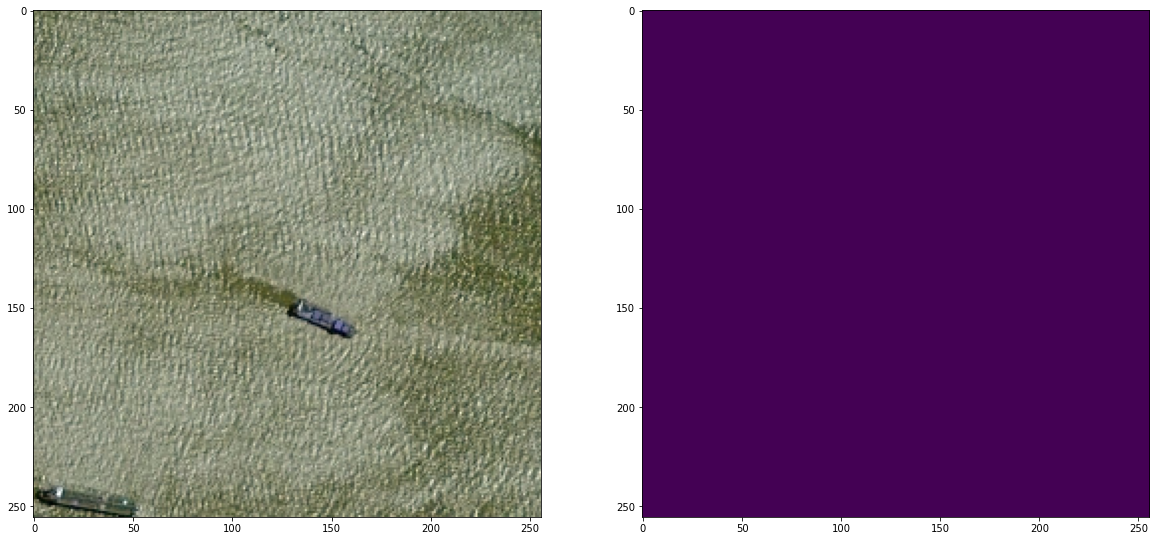

In [146]:
img_id = 10

fig, axs = plt.subplots(1, 2, figsize=(20, 20))

axs[0].imshow(x[img_id])
axs[1].imshow(prediction[img_id, ..., 0] > 0.5)

plt.show()